# Monte Carlo Methods

In this notebook, you will write your own implementations of many Monte Carlo (MC) algorithms. 

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

### Part 0: Explore BlackjackEnv

We begin by importing the necessary packages.

In [15]:
import sys
import gym
import numpy as np
from collections import defaultdict
import pprint

from plot_utils import plot_blackjack_values, plot_policy

Use the code cell below to create an instance of the [Blackjack](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py) environment.

In [16]:
env = gym.make('Blackjack-v0')

/Users/rotobi/anaconda3/envs/deep_rl/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```
Verify this by running the code cell below.

In [17]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


Execute the code cell below to play Blackjack with a random policy.  

(_The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to get some experience with the output that is returned as the agent interacts with the environment._)

In [18]:
for i_episode in range(3):
    state = env.reset()
    while True:
        action = env.action_space.sample()
        print('s:', state, '\ta:', action)
        state, reward, done, info = env.step(action)
        if done:
            print('End game! Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

(12, 10, False)
End game! Reward:  -1
You lost :(

(16, 10, False)
End game! Reward:  -1
You lost :(

(11, 8, False)
(16, 8, False)
(20, 8, False)
End game! Reward:  -1
You lost :(



### Part 1: MC Prediction

In this section, you will write your own implementation of MC prediction (for estimating the action-value function).  

We will begin by investigating a policy where the player _almost_ always sticks if the sum of her cards exceeds 18.  In particular, she selects action `STICK` with 80% probability if the sum is greater than 18; and, if the sum is 18 or below, she selects action `HIT` with 80% probability.  The function `generate_episode_from_limit_stochastic` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [19]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

Execute the code cell below to play Blackjack with the policy. 

(*The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to gain some familiarity with the output of the `generate_episode_from_limit_stochastic` function.*)

In [20]:
for i in range(10):
    print(generate_episode_from_limit_stochastic(env))

[((18, 10, False), 0, 1.0)]
[((15, 2, False), 1, -1)]
[((12, 10, True), 1, 0), ((20, 10, True), 0, 0.0)]


Now, you are ready to write your own implementation of MC prediction.  Feel free to implement either first-visit or every-visit MC prediction; in the case of the Blackjack environment, the techniques are equivalent.

Your algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [38]:
def monitor_progress(i_episode, num_episodes):
    if i_episode % (num_episodes/20) == 0:
            print("\rEpisode {}/{}.\n".format(i_episode, num_episodes), end="")
            sys.stdout.flush()


def is_first_visit(state_t, action_t, episode):
    # In Blackjack, we always have first visits within episodes
    return True

In [54]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=.9):
    # initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):

        monitor_progress(i_episode, num_episodes)
        
        episode = generate_episode(env)
        _, _, episode_reward = episode[-1]
#         print("episode={}, len={}, episode_reward={}".format(i_episode,
#                                                              len(episode),
#                                                              episode_reward))
        
        T = len(episode)-1  # Final time T
        for t, step in enumerate(episode):
            state_t, action_t, reward_t = step
            # Expected return G_t = R_{t+1} + gamma*R{t+2} + gamma^2*R_{t+3} + ...
            # For black jack only the very last t gives us a reward
            G_t = episode_reward * gamma**(T-t)
#             print('\tt={}: s={}, a={}, r={}; G_t={}, T={}'.format(t, state_t, action_t, reward_t, G_t, T))
            
            if is_first_visit(state_t, action_t, episode):
                N[state_t][action_t] += 1
                returns_sum[state_t][action_t] += G_t  # Expected return
                Q[state_t][action_t] = returns_sum[state_t][action_t] / N[state_t][action_t]
    
    print("len(N):", len(N))
    pprint.pprint(N)

    print("len(returns_sum):", len(returns_sum))
    pprint.pprint(returns_sum)
    
    print("len(Q):", len(Q))
    pprint.pprint(Q)
    
    return Q

Use the cell below to obtain the action-value function estimate $Q$.  We have also plotted the corresponding state-value function.

To check the accuracy of your implementation, compare the plot below to the corresponding plot in the solutions notebook **Monte_Carlo_Solution.ipynb**.

Episode 25000/500000.
Episode 50000/500000.
Episode 75000/500000.
Episode 100000/500000.
Episode 125000/500000.
Episode 150000/500000.
Episode 175000/500000.
Episode 200000/500000.
Episode 225000/500000.
Episode 250000/500000.
Episode 275000/500000.
Episode 300000/500000.
Episode 325000/500000.
Episode 350000/500000.
Episode 375000/500000.
Episode 400000/500000.
Episode 425000/500000.
Episode 450000/500000.
Episode 475000/500000.
Episode 500000/500000.
len(N): 280
defaultdict(<function mc_prediction_q.<locals>.<lambda> at 0x1a167f68c8>,
            {(4, 1, False): array([ 58., 175.]),
             (4, 2, False): array([ 41., 184.]),
             (4, 3, False): array([ 40., 151.]),
             (4, 4, False): array([ 57., 185.]),
             (4, 5, False): array([ 31., 178.]),
             (4, 6, False): array([ 50., 176.]),
             (4, 7, False): array([ 44., 185.]),
             (4, 8, False): array([ 48., 185.]),
             (4, 9, False): array([ 45., 164.]),
             (4,

             (8, 8, False): array([-0.5       , -0.35546212]),
             (8, 9, False): array([-0.60323887, -0.45989869]),
             (8, 10, False): array([-0.62043796, -0.48807783]),
             (9, 1, False): array([-0.78947368, -0.42053984]),
             (9, 2, False): array([-0.32475884, -0.1554079 ]),
             (9, 3, False): array([-0.24909747, -0.20414295]),
             (9, 4, False): array([-0.15170279, -0.14532836]),
             (9, 5, False): array([-0.24503311, -0.11340363]),
             (9, 6, False): array([-0.10191083, -0.13759422]),
             (9, 7, False): array([-0.55555556, -0.10451346]),
             (9, 8, False): array([-0.53898305, -0.14125301]),
             (9, 9, False): array([-0.52027027, -0.24040821]),
             (9, 10, False): array([-0.58319605, -0.33411656]),
             (10, 1, False): array([-0.75696203, -0.32502141]),
             (10, 2, False): array([-0.2972973 , -0.04787558]),
             (10, 3, False): array([-0.22162162, -0

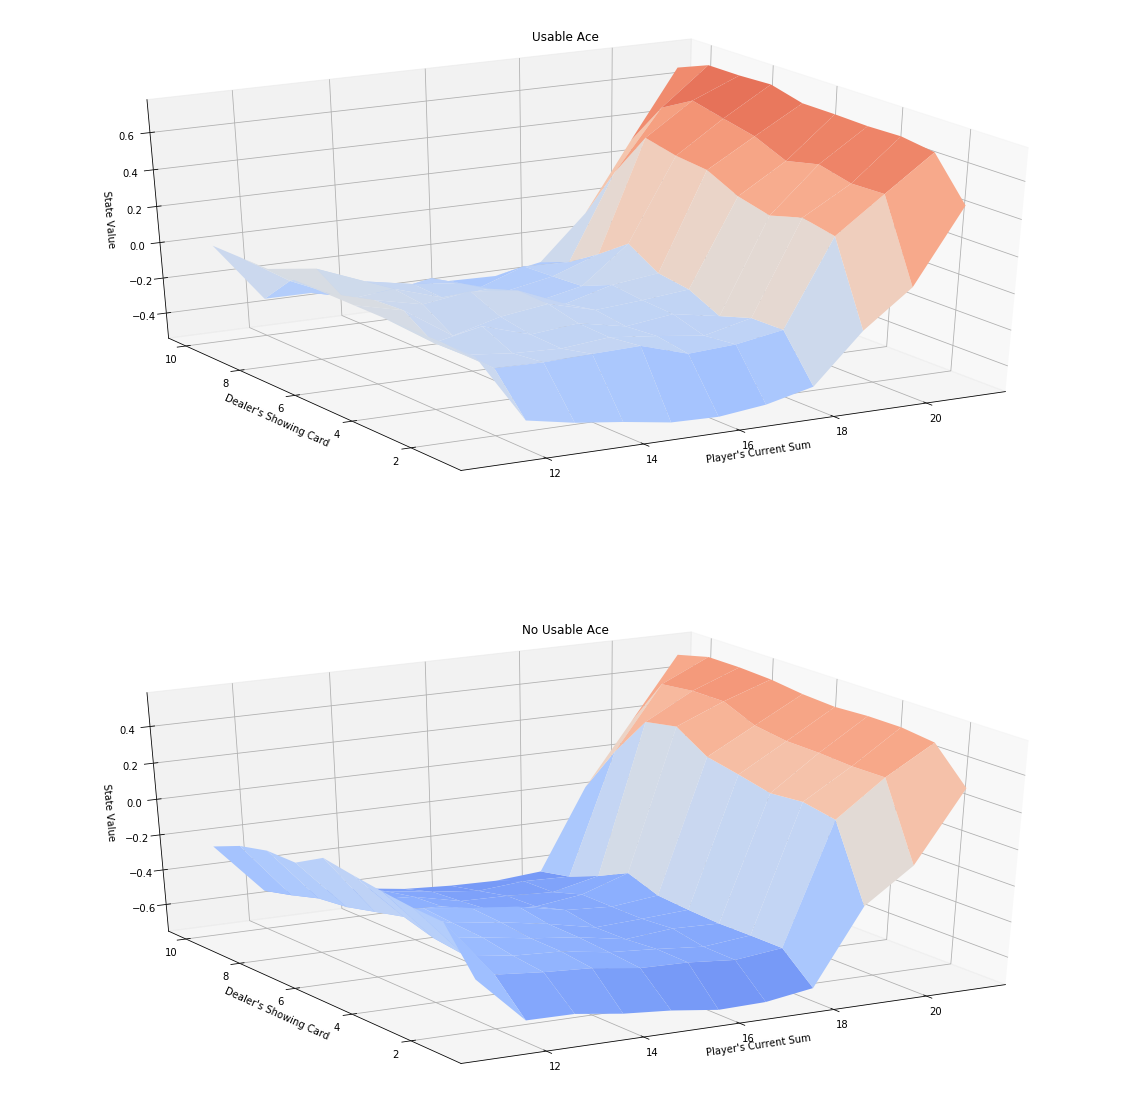

In [71]:
# obtain the action-value function
Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)

# obtain the corresponding state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

### Part 2: MC Control

In this section, you will write your own implementation of constant-$\alpha$ MC control.  

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

(_Feel free to define additional functions to help you to organize your code._)

In [84]:
def decayed_epsilon(i, epsilon_start, epsilon_end, epsilon_fixed_after):
    if i < epsilon_fixed_after:
        epsilon_i = epsilon_start - i*(epsilon_start - epsilon_end)/epsilon_fixed_after
    else:
        epsilon_i = epsilon_end
    return epsilon_i


epsilon_start, epsilon_end = 1.0, 0.1
num_episodes = 1000
epsilon_fixed_after = 0.75 * num_episodes

# for i in range(num_episodes):
#     print(i, decayed_epsilon(i, epsilon_start, epsilon_end, epsilon_fixed_after))

In [ ]:
def mc_control(env, num_episodes, alpha, gamma=1.0):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        
    return policy, Q

Use the cell below to obtain the estimated optimal policy and action-value function.  Note that you should fill in your own values for the `num_episodes` and `alpha` parameters.

In [ ]:
# obtain the estimated optimal policy and action-value function
policy, Q = mc_control(env, ?, ?)

Next, we plot the corresponding state-value function.

In [ ]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

Finally, we visualize the policy that is estimated to be optimal.

In [ ]:
# plot the policy
plot_policy(policy)

The **true** optimal policy $\pi_*$ can be found in Figure 5.2 of the [textbook](http://go.udacity.com/rl-textbook) (and appears below).  Compare your final estimate to the optimal policy - how close are you able to get?  If you are not happy with the performance of your algorithm, take the time to tweak the decay rate of $\epsilon$, change the value of $\alpha$, and/or run the algorithm for more episodes to attain better results.

![True Optimal Policy](images/optimal.png)